# Universidade de Caxias do Sul
# Marcello Fabrizio

Teste de código em Python utilizando o dataset "Pima Indians Diabetes Database" -
Última atualização em: 04/05/2022

In [4]:
# Importaçoes iniciais 
! pip3 install graphviz

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.tree import export_text
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn import tree
from graphviz import Source

import pydotplus
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

# Carrega o dataset
diabetes = pd.read_csv("./diabetes.csv")

Defaulting to user installation because normal site-packages is not writeable


In [5]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Análise estatística do Dataset

In [6]:
diabetes.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


O método **DataFrame.describe()** gera descrições estatísticas que sumarizam a tendência central, disperção dos dados e formato da distribuição, excluindo valores NaN.

In [7]:
diabetes.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


- count retorna o total de valores não vazios de dada característica
- mean retorna a média de característica
- std retorn o desvio padrão da característica
- min retorna o valor mínimo da característica
- 25%, 50% e 75% são os quartis de cada característica
- max retorna o valor máximo da característica

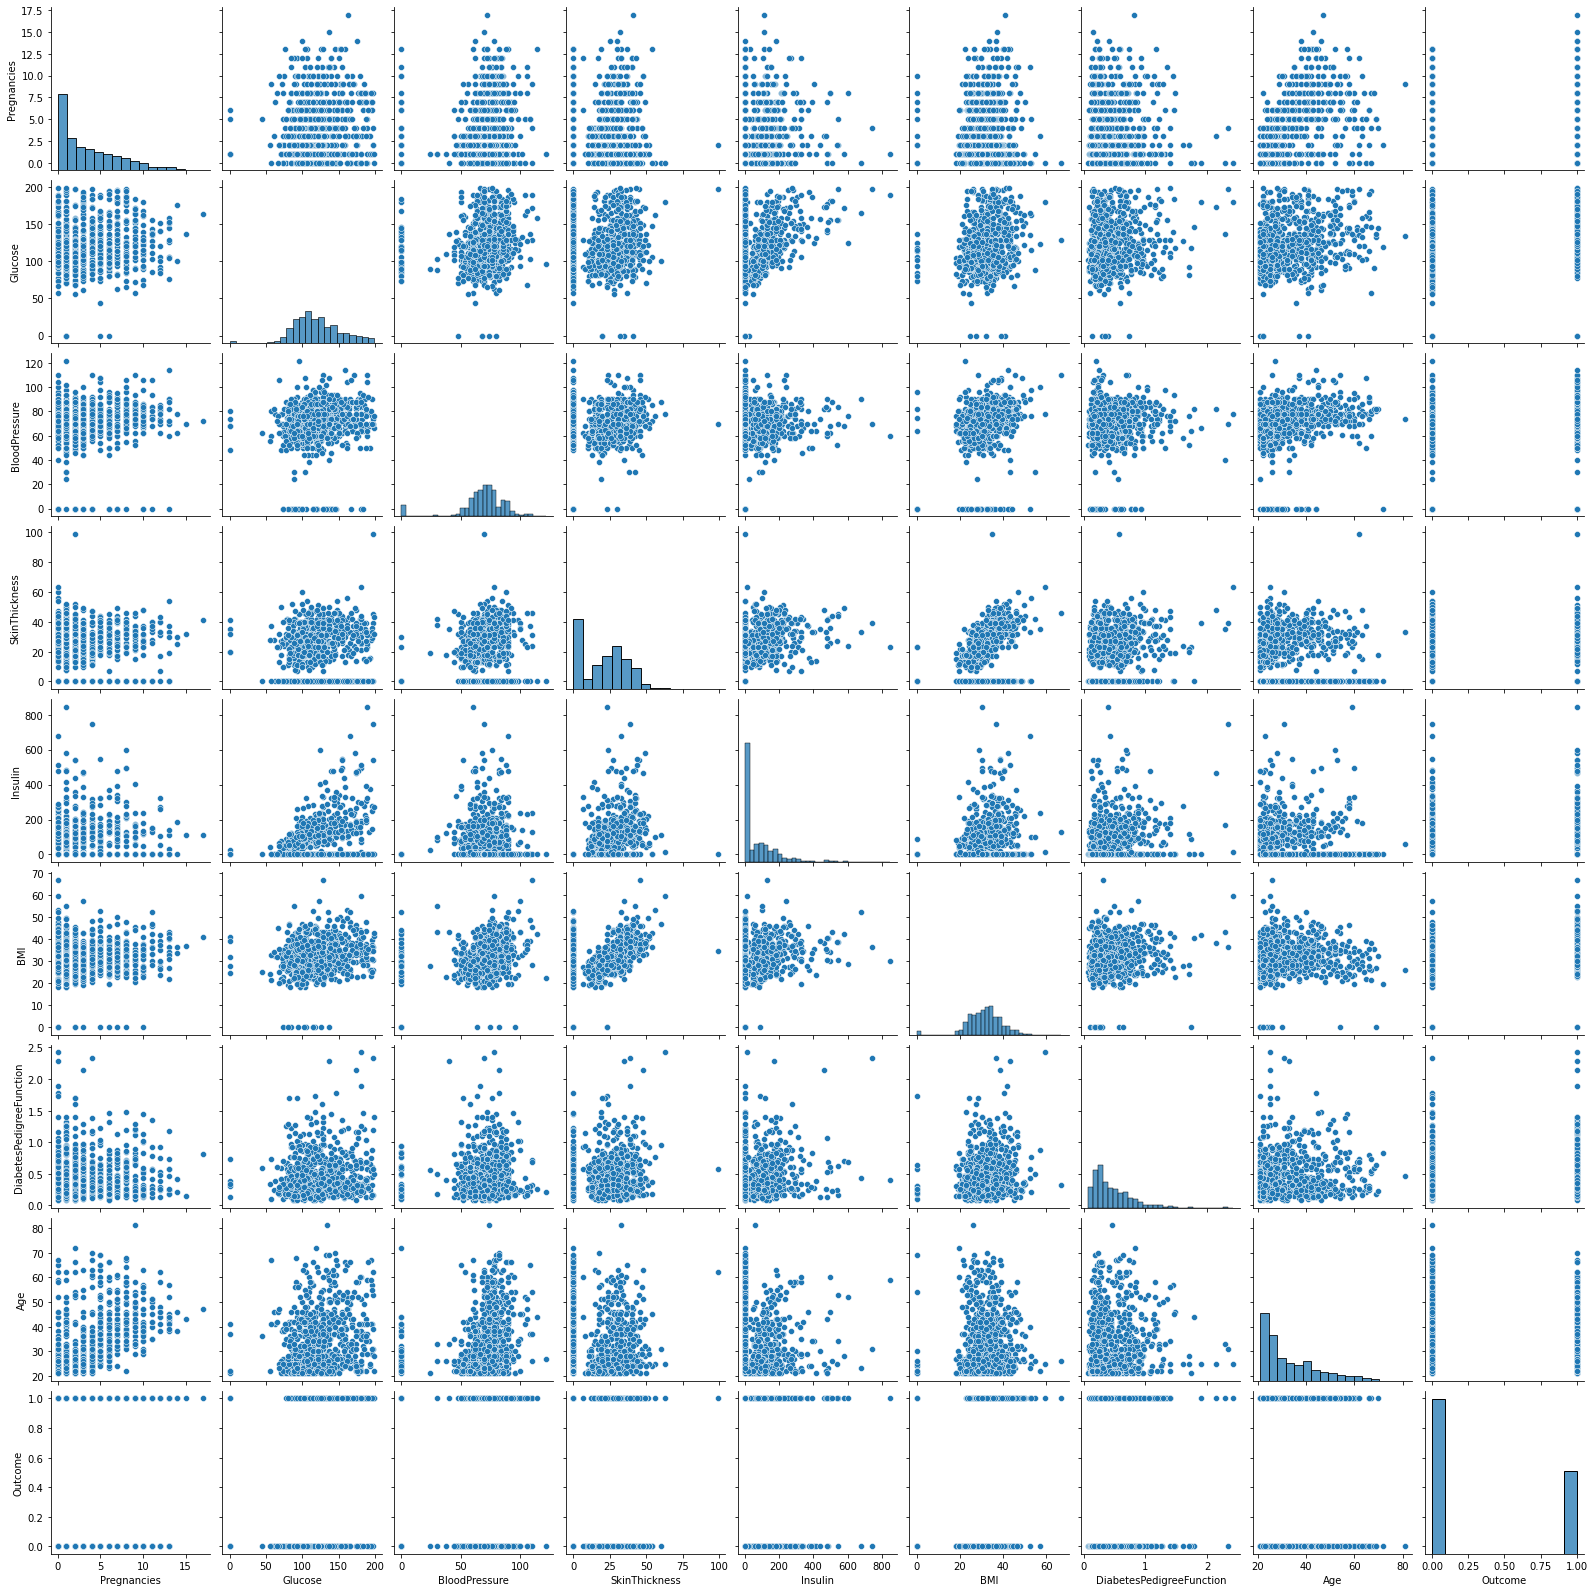

In [8]:
sb.pairplot(diabetes)

In [9]:
# Cria cópia do conjunto de dados
diabetes_copy = diabetes.copy(deep = True)

# Melhor substituir zeros por NaNs
diabetes_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = diabetes_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

# Mostra números de NaNs no conjunto
print(diabetes_copy.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


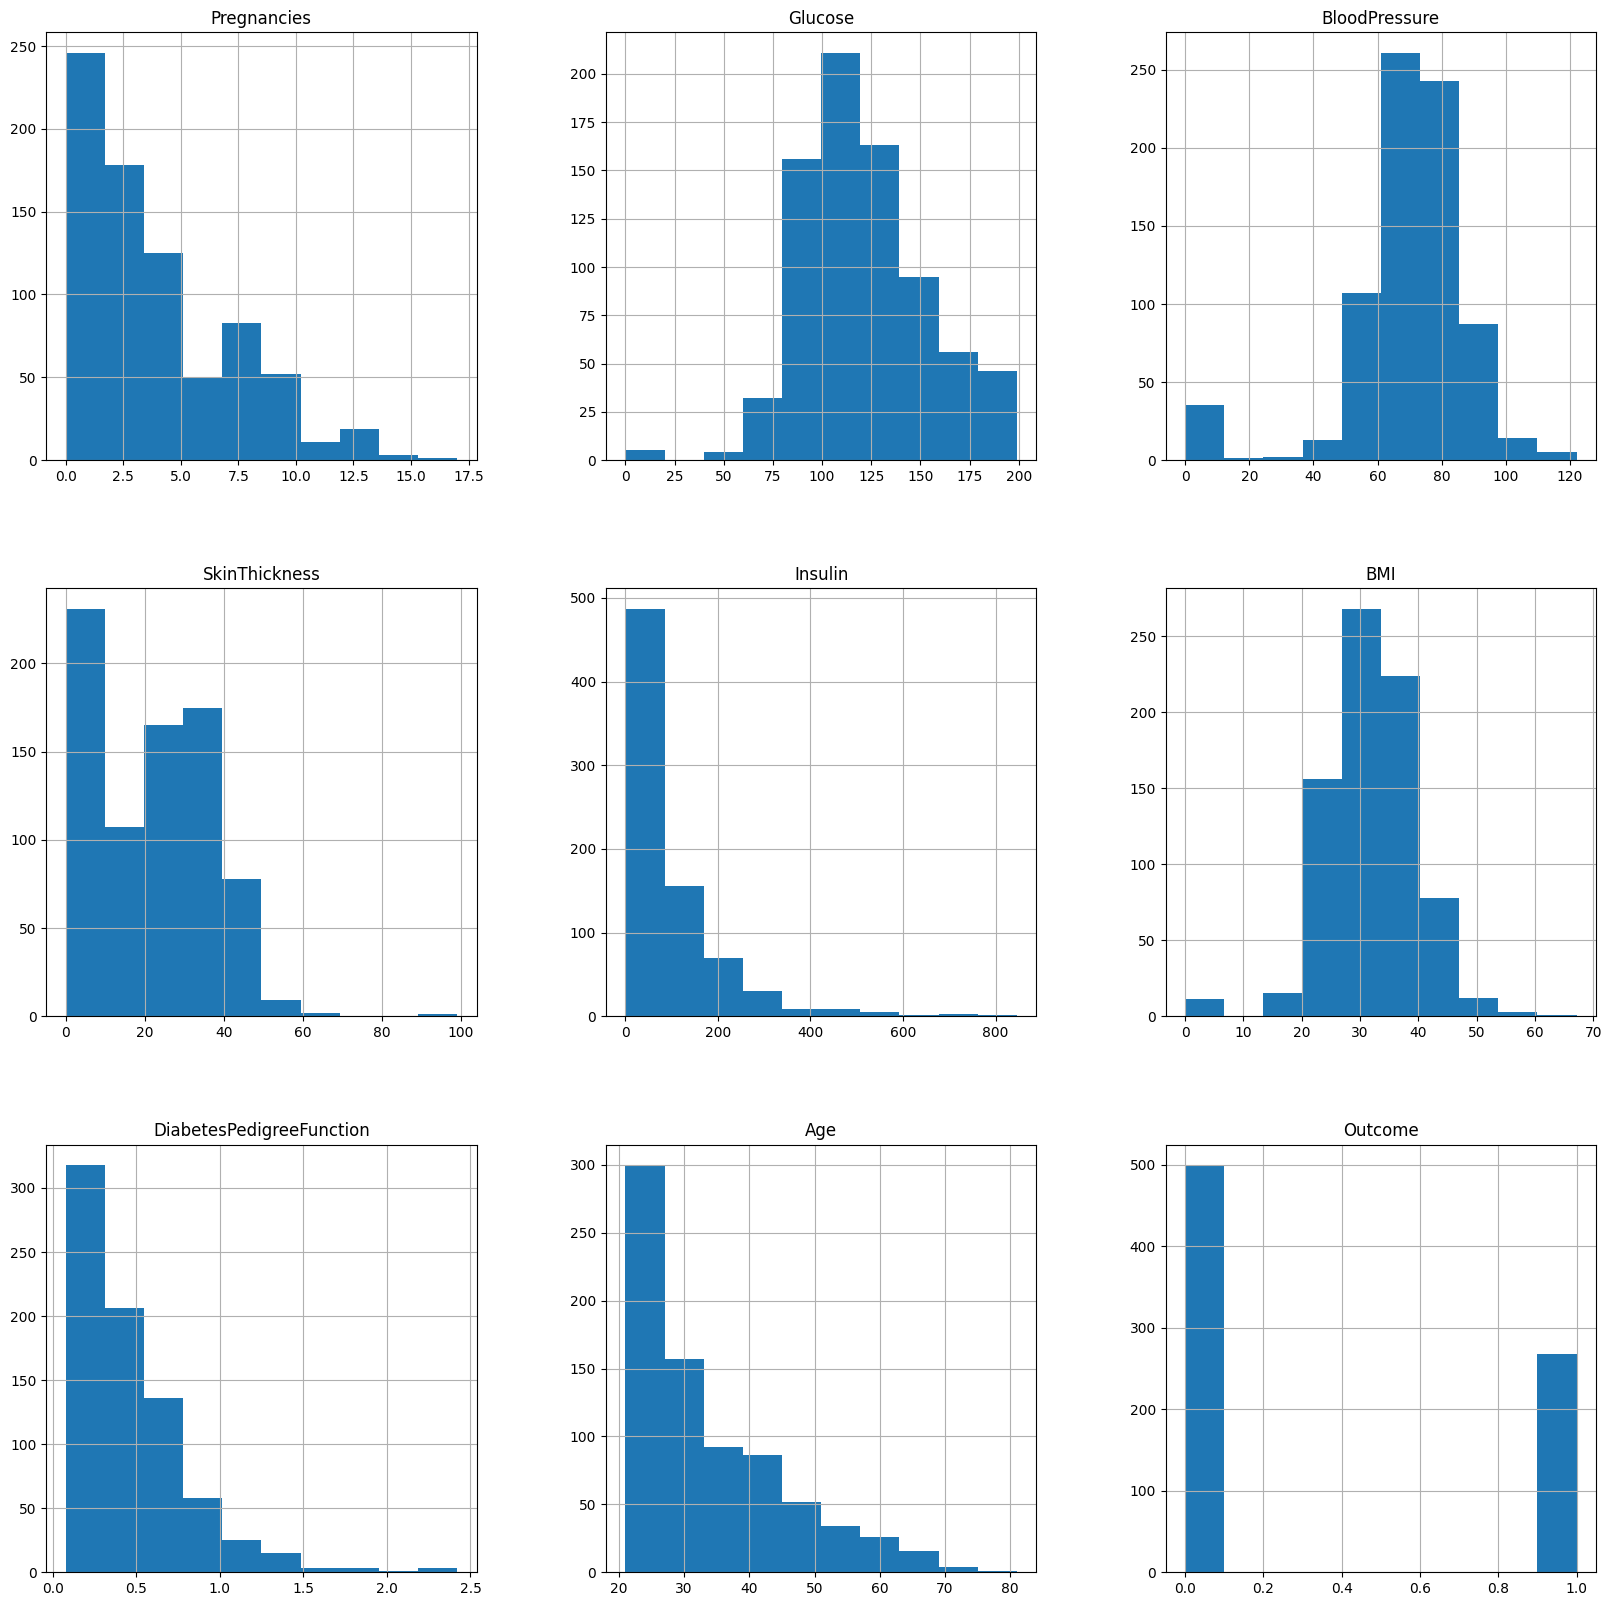

In [10]:
p = diabetes.hist(figsize = (20,20))

Remove NaNs por valores de entrada adequados para o plot

In [11]:
diabetes_copy['Glucose'].fillna(diabetes_copy['Glucose'].mean(), inplace = True)
diabetes_copy['BloodPressure'].fillna(diabetes_copy['BloodPressure'].mean(), inplace = True)
diabetes_copy['SkinThickness'].fillna(diabetes_copy['SkinThickness'].median(), inplace = True)
diabetes_copy['Insulin'].fillna(diabetes_copy['Insulin'].median(), inplace = True)
diabetes_copy['BMI'].fillna(diabetes_copy['BMI'].median(), inplace = True)

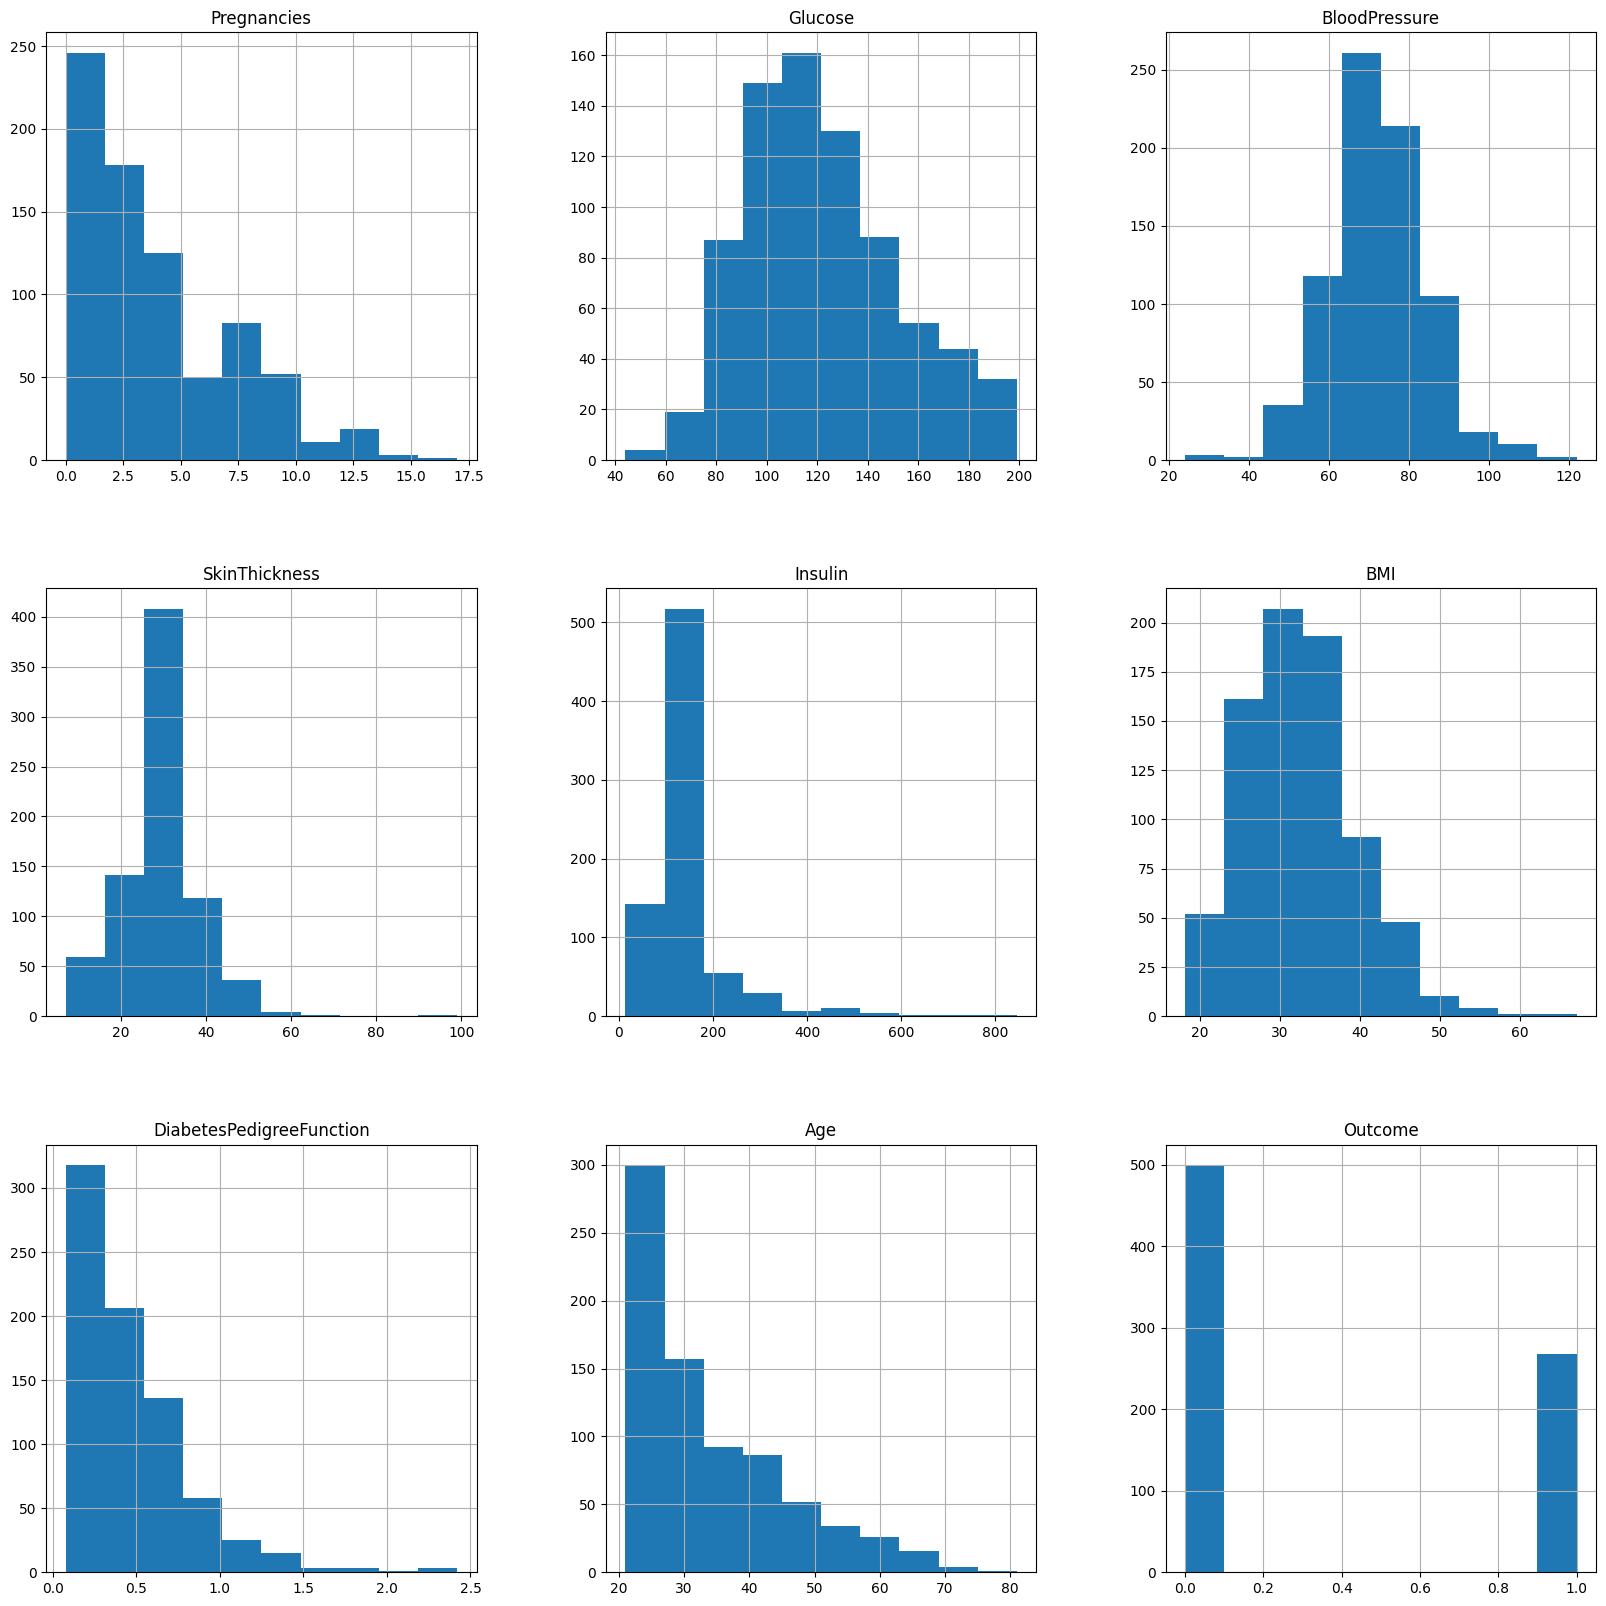

In [12]:
p = diabetes_copy.hist(figsize = (20,20))

Notasse uma diferença ao remover os valores NaN do conjunto

### Método de treinamento da árvore de decisão
#### 1. Separação dos dados de treino e teste


In [13]:
sc_X = StandardScaler()
X =  pd.DataFrame(sc_X.fit_transform(diabetes_copy.drop(["Outcome"],axis = 1),),
        columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'])

X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.865108,-0.033518,0.670643,-0.181541,0.166619,0.468492,1.425995
1,-0.844885,-1.206162,-0.529859,-0.012301,-0.181541,-0.852200,-0.365061,-0.190672
2,1.233880,2.015813,-0.695306,-0.012301,-0.181541,-1.332500,0.604397,-0.105584
3,-0.844885,-1.074652,-0.529859,-0.695245,-0.540642,-0.633881,-0.920763,-1.041549
4,-1.141852,0.503458,-2.680669,0.670643,0.316566,1.549303,5.484909,-0.020496


In [14]:
y = diabetes_copy.Outcome

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### 2. Constrói o objeto da classe Árvore de Decisão e Realiza Predição

In [16]:
model = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
y_pred = model.predict(X_train)
y_prob = model.predict_proba(X_train)[:, 1]
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       377
           1       1.00      1.00      1.00       199

    accuracy                           1.00       576
   macro avg       1.00      1.00      1.00       576
weighted avg       1.00      1.00      1.00       576



In [17]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.71      0.74       123
           1       0.56      0.65      0.60        69

    accuracy                           0.69       192
   macro avg       0.67      0.68      0.67       192
weighted avg       0.70      0.69      0.69       192



### 3. Gera matriz de confusão

<AxesSubplot:>

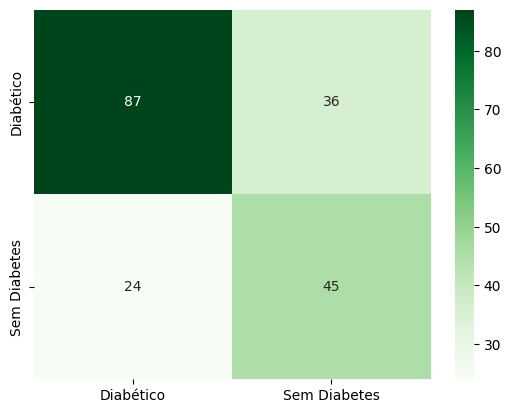

In [18]:
cf = confusion_matrix(y_test,y_pred)
lbl1=['Diabético', 'Sem Diabetes']
lbl2 = ['Diabético', 'Sem Diabetes']
sb.heatmap(cf,annot=True,cmap="Greens", fmt="d",xticklabels=lbl1,yticklabels=lbl2)

In [19]:
print(accuracy_score(y_test,y_pred)*100)

68.75


In [20]:
graph = Source(export_graphviz(model, feature_names=X_train.columns, filled=True, out_file=None))
graph.format = 'png'
graph.render('dtree_render',view=True)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH